<a href="https://colab.research.google.com/github/Yueming02/Datathon/blob/main/Preprocess_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mr.Trump: The Victim of Fake News?

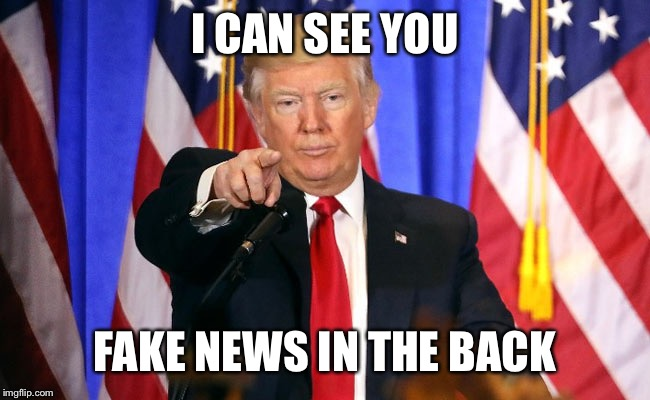

After laughing at those memes on twitter, have you ever wondered if Mr.Trump is acutally a victim of fake news? Or is he just making excuses？

Well, it's a good thing that we now can have an investigation and analysis with a Misinformation, fake news & propaganda dataset! </br>
This is a dataset containing 79k articles of misinformation, fake news and propaganda.

34975 'true' articles. --> MisinfoSuperset_TRUE.csv </br>
43642 articles of misinfo, fake news or propaganda --> MisinfoSuperset_FAKE.csv

**A brief overview: </br>**


*   Preparing the dataset by removing special characters, tokenizing, removing stop words and lemmatizing.
*   Using bigrams to gain some insights about the most common keywords in these news

*   Applying Latent Dirichlet Allocation (LDA) to identify the underlying topics in the news articles
*   Export a dataset with topic labels and probablities data for further analysis

*   Using Tableau to visualize the results










Even though our primary target is Mr.Trump (why do I sound like a journalist?), we will also explore and analyze other topics identified in this dataset, such as minorities, international politics and social welfare, etc. 

In [1]:
import numpy as np 
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


In [4]:
df_true=pd.read_csv('drive/MyDrive/DataSet_Misinfo_TRUE.csv')

In [5]:
df_fake=pd.read_csv('drive/MyDrive/DataSet_Misinfo_FAKE.csv')

In [6]:
df_true['label']=1
df_true=df_true.drop('Unnamed: 0',axis=1)
df_true.head()

,text,label
0,The head of a conservative Republican faction ...,1
1,Transgender people will be allowed for the fir...,1
2,The special counsel investigation of links bet...,1
3,Trump campaign adviser George Papadopoulos tol...,1
4,President Donald Trump called on the U.S. Post...,1


In [7]:
df_fake['label']=0
df_fake=df_fake.drop('Unnamed: 0',axis=1)
df_fake.head()
df_fake.shape

(43642, 2)

In [8]:
df_true.shape

(34975, 2)

In [9]:
df=pd.concat([df_true,df_fake])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78617 entries, 0 to 43641
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    78588 non-null  object
 1   label   78617 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


In [10]:
df=df.dropna(how="any")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78588 entries, 0 to 43641
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    78588 non-null  object
 1   label   78588 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


In [11]:
df.shape

(78588, 2)

## Prepare the data by cleaning the text

In [14]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [17]:
# Function to clean text
def clean_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    # Remove special characters
    text = re.sub(r'[^\w\s]|_', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    # Remove stop words
    stop_words = set(nltk.corpus.stopwords.words("english"))
    filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_paragraph = [lemmatizer.lemmatize(word) for word in filtered_words]
    # Join the words back into a string
    clean_text = ' '.join(lemmatized_paragraph)
    return clean_text

# Apply the clean_text function to the 'text' column
df['clean_text'] = df['text'].apply(clean_text)

# View the results
print(df.head)



<bound method NDFrame.head of                                                     text  label  \
0      The head of a conservative Republican faction ...      1   
1      Transgender people will be allowed for the fir...      1   
2      The special counsel investigation of links bet...      1   
3      Trump campaign adviser George Papadopoulos tol...      1   
4      President Donald Trump called on the U.S. Post...      1   
...                                                  ...    ...   
43637  The USA wants to divide Syria.\r\n\r\nGreat Br...      0   
43638  The Ukrainian coup d'etat cost the US nothing ...      0   
43639  The European Parliament falsifies history by d...      0   
43640  The European Parliament falsifies history by d...      0   
43641  A leading FSB officer, Segey Beseda, said duri...      0   

                                              clean_text  
0      head conservative republican faction u congres...  
1      transgender people allowed first time en

In [13]:
type(df['clean_text'])

pandas.core.series.Series

In [ ]:
df.shape

(78588, 3)

## Bigrams summary

Let's see how popular Mr.Trump is to journalists and journalism brands.
We're going to use N-grams to help us get a summary of the dataset. 

In [31]:
import nltk
from nltk.util import ngrams

textcleaned = ' '.join(df['text'].apply(clean_text))
# Tokenize the text and generate a list of unigrams, bigrams, and trigrams
tokens = nltk.word_tokenize(textcleaned)
unigrams = ngrams(tokens, 1)
bigrams = ngrams(tokens, 2)
trigrams = ngrams(tokens, 3)

# Print the top 10 most common bigrams
freq_dist = nltk.FreqDist(bigrams)
print(freq_dist.most_common(10))

[(('donald', 'trump'), 38213), (('united', 'state'), 32163), (('white', 'house'), 22007), (('hillary', 'clinton'), 21779), (('mr', 'trump'), 18946), (('new', 'york'), 18058), (('last', 'year'), 9046), (('president', 'donald'), 7899), (('last', 'week'), 7512), (('north', 'korea'), 7007)]


Holy Moly! Among the most common 10 bigrams, 3 of them are associated with Mr. Trump. And of course, the top spot too.

So they do have a preference for Mr. Trump. You might be thinking, how likely is it that news involving Donald Trump is fake? </br>
Now we are going to do some topic modeling, and see if the topic of news involves Donald Trump will it more likely be fake comparing to news with other topics.


## Topic Modeling

**Topic modeling:** Use techniques such as Latent Dirichlet Allocation (LDA) to identify the underlying topics in the news articles. This can provide insights into the main themes of the dataset and how they relate to true and fake news.

In [19]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# Define stop words
stop_words = set(STOPWORDS)

# Define function to preprocess text
def preprocess(text):
    result = []
    for token in simple_preprocess(text):
        if token not in stop_words and len(token) > 3:
            result.append(token)
    return result

# Preprocess text data
processed_data = []
for doc in df['clean_text']:
  processed_data.append(preprocess(doc))

# Create dictionary
dictionary = corpora.Dictionary(processed_data)

# Convert corpus to bag of words format
corpus = [dictionary.doc2bow(doc) for doc in processed_data]

# Build LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=7, passes=10)

# Print topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))


Topic: 0 
Words: 0.011*"people" + 0.010*"like" + 0.008*"time" + 0.007*"know" + 0.005*"medium" + 0.005*"thing" + 0.005*"world" + 0.005*"think" + 0.004*"want" + 0.004*"american"
Topic: 1 
Words: 0.022*"muslim" + 0.013*"refugee" + 0.011*"country" + 0.009*"border" + 0.009*"immigration" + 0.009*"immigrant" + 0.008*"migrant" + 0.007*"illegal" + 0.006*"united" + 0.006*"terrorist"
Topic: 2 
Words: 0.015*"russia" + 0.011*"state" + 0.010*"russian" + 0.009*"military" + 0.008*"ukraine" + 0.008*"country" + 0.008*"syria" + 0.007*"government" + 0.006*"force" + 0.006*"said"
Topic: 3 
Words: 0.013*"said" + 0.012*"police" + 0.008*"people" + 0.007*"right" + 0.006*"city" + 0.006*"court" + 0.006*"state" + 0.006*"black" + 0.006*"school" + 0.006*"officer"
Topic: 4 
Words: 0.058*"trump" + 0.021*"clinton" + 0.018*"election" + 0.016*"hillary" + 0.016*"president" + 0.014*"donald" + 0.013*"republican" + 0.012*"obama" + 0.011*"vote" + 0.011*"campaign"
Topic: 5 
Words: 0.025*"clinton" + 0.017*"email" + 0.012*"hilla

In [20]:
# Get the topic distributions for each document in the dataset
doc_topic = np.array([lda_model.get_document_topics(doc, minimum_probability=0) for doc in corpus])

# Print the topic distributions for the first 5 documents
for i in range(5):
    print(f"Document {i}: {doc_topic[i]}")


Document 0: [[0.00000000e+00 3.89187655e-04]
 [1.00000000e+00 3.93940657e-02]
 [2.00000000e+00 3.89217865e-04]
 [3.00000000e+00 3.89721623e-04]
 [4.00000000e+00 6.02343976e-01]
 [5.00000000e+00 3.88878892e-04]
 [6.00000000e+00 3.56704980e-01]]
Document 1: [[0.00000000e+00 7.00772449e-04]
 [1.00000000e+00 6.99763012e-04]
 [2.00000000e+00 1.58694953e-01]
 [3.00000000e+00 4.97025281e-01]
 [4.00000000e+00 2.27073446e-01]
 [5.00000000e+00 9.89911631e-02]
 [6.00000000e+00 1.68146379e-02]]
Document 2: [[0.00000000e+00 6.52174931e-04]
 [1.00000000e+00 6.50825619e-04]
 [2.00000000e+00 6.31600991e-02]
 [3.00000000e+00 6.51961600e-04]
 [4.00000000e+00 4.29237038e-01]
 [5.00000000e+00 5.04996479e-01]
 [6.00000000e+00 6.51417358e-04]]
Document 3: [[0.00000000e+00 1.30424201e-02]
 [1.00000000e+00 2.67970040e-02]
 [2.00000000e+00 8.54740888e-02]
 [3.00000000e+00 7.38042931e-04]
 [4.00000000e+00 1.99544832e-01]
 [5.00000000e+00 6.73665047e-01]
 [6.00000000e+00 7.38571980e-04]]
Document 4: [[0.00000000

In [21]:
df_topic = pd.DataFrame(doc_topic.reshape(-1, 2), columns=['topic', 'probability'])

# repeat index 1,2,3,4,5 78588 times
df_topic.index = np.concatenate([np.repeat([i], 7) for i in range(78588)])

# preview the resulting dataframe
print(df_topic.head(15))


   topic  probability
0    0.0     0.000389
0    1.0     0.039394
0    2.0     0.000389
0    3.0     0.000390
0    4.0     0.602344
0    5.0     0.000389
0    6.0     0.356705
1    0.0     0.000701
1    1.0     0.000700
1    2.0     0.158695
1    3.0     0.497025
1    4.0     0.227073
1    5.0     0.098991
1    6.0     0.016815
2    0.0     0.000652


In [22]:
df = df.reset_index()
df1 = pd.concat([df, df_topic], axis=1)

In [26]:
print(df1.tail(10))

       index                                               text  label  \
78586  43640  The European Parliament falsifies history by d...      0   
78586  43640  The European Parliament falsifies history by d...      0   
78586  43640  The European Parliament falsifies history by d...      0   
78587  43641  A leading FSB officer, Segey Beseda, said duri...      0   
78587  43641  A leading FSB officer, Segey Beseda, said duri...      0   
78587  43641  A leading FSB officer, Segey Beseda, said duri...      0   
78587  43641  A leading FSB officer, Segey Beseda, said duri...      0   
78587  43641  A leading FSB officer, Segey Beseda, said duri...      0   
78587  43641  A leading FSB officer, Segey Beseda, said duri...      0   
78587  43641  A leading FSB officer, Segey Beseda, said duri...      0   

                                              clean_text  topic  probability  
78586  european parliament falsifies history declarin...    4.0     0.002319  
78586  european parliament 

# Topic Labels

Now I want to manually give each topic a label that seem to be able to describe it, based on the 10 identified words each topic has in our previous output.

For example,</br>
Topic: 1 </br>
*Words: 0.022*"muslim" + 0.013*"refugee" + 0.011*"country" + 0.009*"border" + 0.009*"immigration" + 0.009*"immigrant" + 0.008*"migrant" + 0.007*"illegal" + 0.006*"united" + 0.006*"terrorist"* 
</br>
I'll label this topic as "Minority Communities", and some keywords are "muslim, refugee, border, immigration".

In [33]:
data = {'topic':[0,1,2,3,4,5,6],
        "Type":['Public Opinion','Minority Communities','International Politics','Police Brutality Related','Election'
        ,'Scandal Investigation', 'Social Welfare'],
        "Keywords":['people, like, world, american', 'muslim, refugee, border, immigration', 'russia, military, ukraine, syria',
               'police，people, right, court, black','trump, clinton, election, republican', 'clinton, email, investigation, information'
        , 'million, government, health, food']}
df_topicslabel = pd.DataFrame(data)

print(df_topicslabel)

   topic                      Type                                    Keywords
0      0            Public Opinion               people, like, world, american
1      1      Minority Communities        muslim, refugee, border, immigration
2      2    International Politics            russia, military, ukraine, syria
3      3  Police Brutality Related          police，people, right, court, black
4      4                  Election        trump, clinton, election, republican
5      5     Scandal Investigation  clinton, email, investigation, information
6      6            Social Welfare           million, government, health, food


In [34]:
df_final = df1.join(df_topicslabel, on = 'topic', lsuffix="_left")
df_final = df_final.drop(['text','clean_text', 'topic_left'], axis=1)
print(df_final.head(10))

   index  label  probability  topic                      Type  \
0      0      1     0.000389      0            Public Opinion   
0      0      1     0.039394      1      Minority Communities   
0      0      1     0.000389      2    International Politics   
0      0      1     0.000390      3  Police Brutality Related   
0      0      1     0.602344      4                  Election   
0      0      1     0.000389      5     Scandal Investigation   
0      0      1     0.356705      6            Social Welfare   
1      1      1     0.000701      0            Public Opinion   
1      1      1     0.000700      1      Minority Communities   
1      1      1     0.158695      2    International Politics   

                                     Keywords  
0               people, like, world, american  
0        muslim, refugee, border, immigration  
0            russia, military, ukraine, syria  
0          police，people, right, court, black  
0        trump, clinton, election, republica

In [35]:
df_final.to_csv('drive/MyDrive/DataProcessed_V1.csv')

Now we'll go to tableau to see what we can do with this new dataset.

***Some words at the end...</br>
Thank you for reviewing my submission and I apologize if the code/analysis makes no sense. This is my first datathon and it's more like my machine learning 101, as I have no experience with machine learning before.</br>
I sincerely appreciate your efforts in organizing this event and providing an opportunity for people like me to learn and explore machine learning. The 48 hours is a great journey, full of meaningful experiences.
Thank you!***

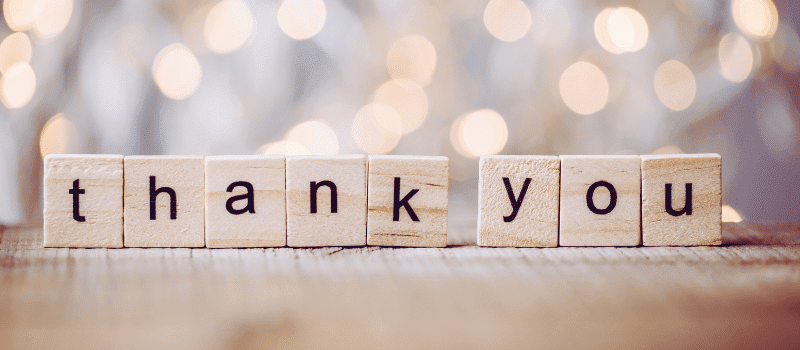